In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csav)

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

import os

In [6]:
import os
import pandas as pd

# 初始化 DataFrame
Ravdess = pd.DataFrame({
    'emotions': [],
    'path': []
})

# 数据集路径
Ravdess_dir = "Ravdess"

# 检查目录是否存在
if not os.path.exists(Ravdess_dir):
    raise FileNotFoundError(f"Directory '{Ravdess_dir}' does not exist.")

# 遍历子文件夹和文件
for dir in os.listdir(Ravdess_dir):
    if not dir.startswith('.'):  # 忽略隐藏文件（如 .DS_Store）
        actor_path = os.path.join(Ravdess_dir, dir)  # 拼接路径
        if os.path.isdir(actor_path):  # 确保是目录
            for file in os.listdir(actor_path):
                audio_path = os.path.join(actor_path, file)  # 拼接文件路径
                if file.endswith('.wav'):  # 只处理 .wav 文件
                    id_arr = file.split('-')
                    emo_id = id_arr[2]  # 提取情感 ID
                    # 映射情感 ID 到标签
                    if emo_id == '01':
                        emo = 'neutral'
                    elif emo_id == '02':
                        emo = 'calm'
                    elif emo_id == '03':
                        emo = 'happy'
                    elif emo_id == '04':
                        emo = 'sad'
                    elif emo_id == '05':
                        emo = 'angry'
                    elif emo_id == '06':
                        emo = 'fearful'
                    elif emo_id == '07':
                        emo = 'disgust'
                    else:
                        emo = 'surprised'
                    
                    # 将数据添加到 DataFrame
                    new_data = pd.DataFrame({'emotions': [emo], 'path': [audio_path]})
                    Ravdess = pd.concat([Ravdess, new_data], ignore_index=True)

# 转换 emotions 列为分类变量
Ravdess['emotions'] = pd.Categorical(Ravdess['emotions'])

# 输出生成的 DataFrame
print(Ravdess)


     emotions                                       path
0       angry  Ravdess/Actor_16/03-01-05-01-02-01-16.wav
1     fearful  Ravdess/Actor_16/03-01-06-01-02-02-16.wav
2     fearful  Ravdess/Actor_16/03-01-06-02-01-02-16.wav
3       angry  Ravdess/Actor_16/03-01-05-02-01-01-16.wav
4     disgust  Ravdess/Actor_16/03-01-07-01-01-01-16.wav
...       ...                                        ...
1435    happy  Ravdess/Actor_08/03-01-03-02-02-02-08.wav
1436    happy  Ravdess/Actor_08/03-01-03-01-01-02-08.wav
1437     calm  Ravdess/Actor_08/03-01-02-02-01-01-08.wav
1438     calm  Ravdess/Actor_08/03-01-02-01-02-01-08.wav
1439  neutral  Ravdess/Actor_08/03-01-01-01-02-02-08.wav

[1440 rows x 2 columns]


In [7]:
Ravdess['emotions'].value_counts()

emotions
angry        192
calm         192
disgust      192
fearful      192
happy        192
sad          192
surprised    192
neutral       96
Name: count, dtype: int64

/var/folders/tx/hpsj6hmd5d35_szvgyc0nt3w0000gn/T/ipykernel_63630/2869781264.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Ravdess, x='emotions', palette='husl')  # 使用 Husl 色彩方案


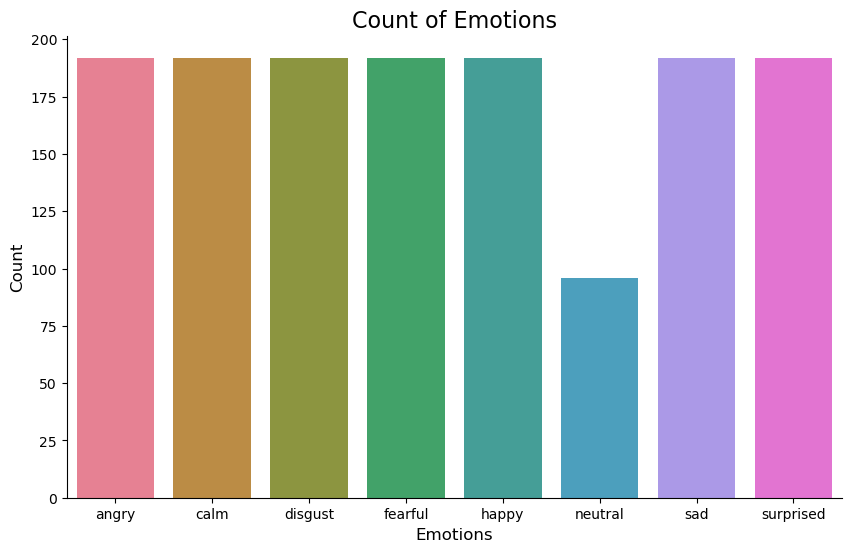

In [8]:
plt.figure(figsize=(10, 6))  # 调整图表大小
plt.title('Count of Emotions', size=16)
sns.countplot(data=Ravdess, x='emotions', palette='husl')  # 使用 Husl 色彩方案
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [9]:
import os
import pandas as pd

# 初始化路径和标签列表
paths, labels = [], []

# 数据集根目录
SAVEE_dir = "savee"

# 遍历文件夹
for dirname, _, filenames in os.walk(SAVEE_dir):
    for filename in filenames:
        if filename.endswith('.wav'):  # 只处理 .wav 文件
            # 构建完整路径
            file_path = os.path.join(dirname, filename)
            paths.append(file_path)
            
            # 从文件名解析情感标签
            label = filename[::-1].split('_')[0][::-1]  # 提取文件名中情感标签部分
            if label[:1] == 'a':
                labels.append('angry')
            elif label[:1] == 'd':
                labels.append('disgust')
            elif label[:1] == 'f':
                labels.append('fearful')
            elif label[:1] == 'h':
                labels.append('happy')
            elif label[:1] == 'n':
                labels.append('neutral')
            elif label[:1] == 's':
                if label[:2] == 'sa':
                    labels.append('sad')
                else:
                    labels.append('surprised')

# 检查路径和标签列表的长度是否一致
if len(paths) != len(labels):
    print(f"Error: Number of paths ({len(paths)}) does not match number of labels ({len(labels)})")
else:
    # 创建 DataFrame
    SAVEE = pd.DataFrame({'emotions': labels, 'path': paths})
    print(f"DataFrame created successfully with {len(SAVEE)} entries.")
    print(SAVEE)  # 查看前几行


DataFrame created successfully with 480 entries.
      emotions               path
0          sad  savee/JK_sa01.wav
1          sad  savee/JK_sa15.wav
2      neutral   savee/DC_n13.wav
3    surprised  savee/DC_su09.wav
4      neutral   savee/DC_n07.wav
..         ...                ...
475      angry   savee/JE_a01.wav
476      angry   savee/JE_a15.wav
477    neutral   savee/DC_n22.wav
478  surprised  savee/DC_su04.wav
479  surprised  savee/DC_su10.wav

[480 rows x 2 columns]


/var/folders/tx/hpsj6hmd5d35_szvgyc0nt3w0000gn/T/ipykernel_63630/317832223.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=SAVEE, x='emotions',palette='husl')


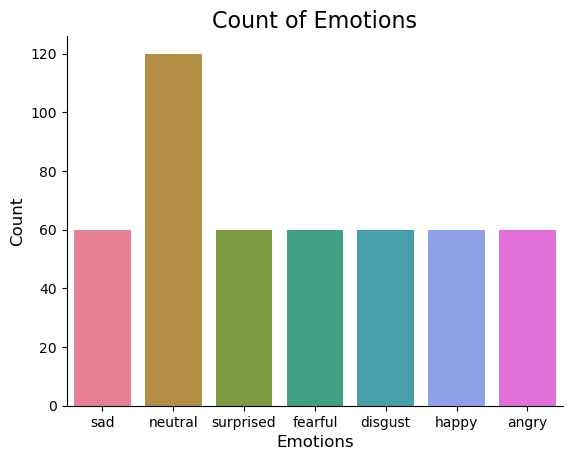

In [10]:
plt.title('Count of Emotions', size=16)
sns.countplot(data=SAVEE, x='emotions',palette='husl')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [11]:
import os
import pandas as pd

# 初始化 DataFrame
TESS = pd.DataFrame({
    'emotions': [],
    'path': []
})

# 数据集路径
TESS_dir = "tess"

# 遍历文件夹和文件
for dirname, _, filenames in os.walk(TESS_dir):
    for filename in filenames:
        if filename.startswith('.'):  # 跳过隐藏文件
            continue
        if not filename.endswith('.wav'):  # 跳过非音频文件
            continue
        
        # 构建文件路径
        audio_path = os.path.join(dirname, filename)
        
        # 提取情感标签
        emo = filename.split('_')[-1]  # 提取情感部分
        emo_tag = emo.split('.')[0]  # 去掉扩展名
        
        # 映射标签到情感类别
        if emo_tag == 'fear':
            emo = 'fearful'
        elif emo_tag == 'ps':
            emo = 'surprised'
        elif emo_tag == 'sad':
            emo = 'sad'
        elif emo_tag == 'happy':
            emo = 'happy'
        elif emo_tag == 'neutral':
            emo = 'neutral'
        elif emo_tag == 'angry':
            emo = 'angry'
        elif emo_tag == 'disgust':
            emo = 'disgust'
        else:
            print(f"Unknown emotion tag: {emo_tag}")  # 打印未知标签
            continue
        
        # 添加到 DataFrame
        new_data = pd.DataFrame({'emotions': [emo], 'path': [audio_path]})
        TESS = pd.concat([TESS, new_data], ignore_index=True)

# 转换 emotions 列为分类变量
TESS['emotions'] = pd.Categorical(TESS['emotions'])

# 打印 DataFrame 概览
print(f"Total entries: {len(TESS)}")
print(TESS)


Total entries: 2800
     emotions                                    path
0     disgust   tess/YAF_disgust/YAF_date_disgust.wav
1     disgust    tess/YAF_disgust/YAF_rag_disgust.wav
2     disgust  tess/YAF_disgust/YAF_raise_disgust.wav
3     disgust  tess/YAF_disgust/YAF_ditch_disgust.wav
4     disgust   tess/YAF_disgust/YAF_door_disgust.wav
...       ...                                     ...
2795      sad           tess/OAF_Sad/OAF_tool_sad.wav
2796      sad          tess/OAF_Sad/OAF_goose_sad.wav
2797      sad            tess/OAF_Sad/OAF_met_sad.wav
2798      sad          tess/OAF_Sad/OAF_pearl_sad.wav
2799      sad           tess/OAF_Sad/OAF_rain_sad.wav

[2800 rows x 2 columns]


/var/folders/tx/hpsj6hmd5d35_szvgyc0nt3w0000gn/T/ipykernel_63630/3870208913.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot (data=TESS, x ='emotions',palette='husl')


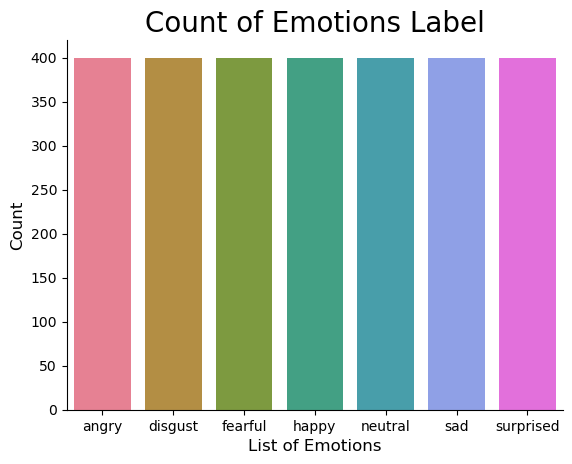

In [12]:
plt.title ("Count of Emotions Label",fontsize = 20)
sns.countplot (data=TESS, x ='emotions',palette='husl')
plt.xlabel ('List of Emotions',fontsize = 12)
plt.ylabel ('Count',fontsize = 12)
sns.despine (top=True, right = True,left =False,bottom=False)
plt.show ()

In [13]:
def create_wave_plot (data_path, emo):
    audio, sr = librosa.load(data_path)
    plt.figure(figsize=(10,3))
    plt.title(f'Waveplot for audio with {emo} emotion', size=16)
    librosa.display.waveshow(audio, sr=sr)
    plt.show()

def show_melspectrogram (data_path, emo):
    S_db, sr = create_melspectrogram (data_path)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, y_axis='mel', x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for audio with {emo} emotion')
    plt.tight_layout()
    plt.show()

def create_melspectrogram (data_path):
    audio, sr = librosa.load(data_path, sr=22050)
    n_frames = int(sr*1.2)
    start_frame = int(len(audio) // 2 - n_frames // 2)
    end_frame = start_frame + n_frames
    audio_cut = audio[start_frame:end_frame]
    S = librosa.feature.melspectrogram(y=audio_cut, sr=sr, n_mels=128, n_fft=1024, hop_length=512)
    S_db =librosa.power_to_db(S, ref=np.min)
    return S_db, sr
                                    
def create_mfcc (audio, sr):
    n_frames = int(sr*1.2)
    start_frame = int(len(audio) // 2 - n_frames // 2)
    end_frame = start_frame + n_frames
    audio_cut = audio[start_frame:end_frame]
    feature = np.mean(librosa.feature.mfcc(y=audio_cut,sr=sr,n_mfcc=40).T,axis=0)
    return feature

def create_origin_mfcc (data_path):
    S, sr = librosa.load(data_path)
    feature = create_mfcc(S,sr)
    return feature

def create_noise_mfcc (data_path):
    S, sr = librosa.load(data_path)
    noise_amp = 0.035*np.random.uniform()*np.amax(S)
    S = S + noise_amp*np.random.normal(size=S.shape[0])
    feature = create_mfcc(S,sr)
    return feature

def create_pitch_mfcc (data_path):
    S, sr = librosa.load(data_path)
    S = librosa.effects.pitch_shift(y=S, sr=sr, n_steps=0.7)
    feature = create_mfcc(S,sr)
    return feature

def create_stretch_mfcc (data_path):
    S, sr = librosa.load(data_path)
    S = librosa.effects.time_stretch(y=S, rate=0.85)
    feature = create_mfcc(S,sr)
    return feature

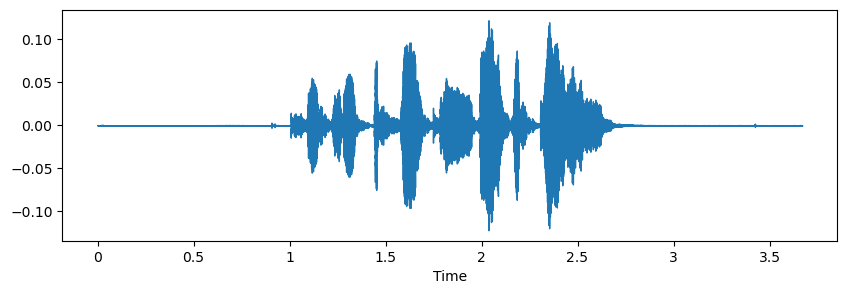

In [14]:
path_happy = np.array(Ravdess.path[Ravdess.emotions=='happy'])[1]
S, sr = librosa.load(path_happy)
plt.figure(figsize=(10,3))
librosa.display.waveshow(S, sr=sr)
plt.show()

In [15]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 读取 happy 类别的音频文件路径
path_happy = np.array(Ravdess.path[Ravdess.emotions == 'happy'])[1]

# 读取音频数据
y, sr = librosa.load(path_happy, sr=None)

# 生成并保存波形图
waveform_path = "F3_waveform_happy.png"
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform - Happy Emotion")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.savefig(waveform_path)
plt.close()

# 计算梅尔频谱图
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

# 生成并保存频谱图
spectrogram_path = "F4_spectrogram_happy.png"
plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram - Happy Emotion")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.savefig(spectrogram_path)
plt.close()

# 返回生成的文件路径
waveform_path, spectrogram_path


('F3_waveform_happy.png', 'F4_spectrogram_happy.png')

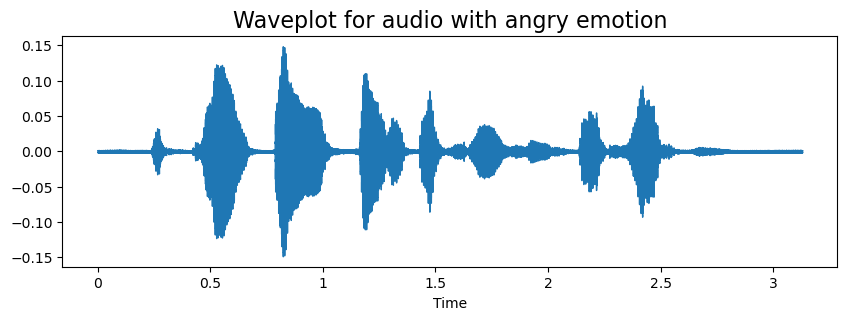

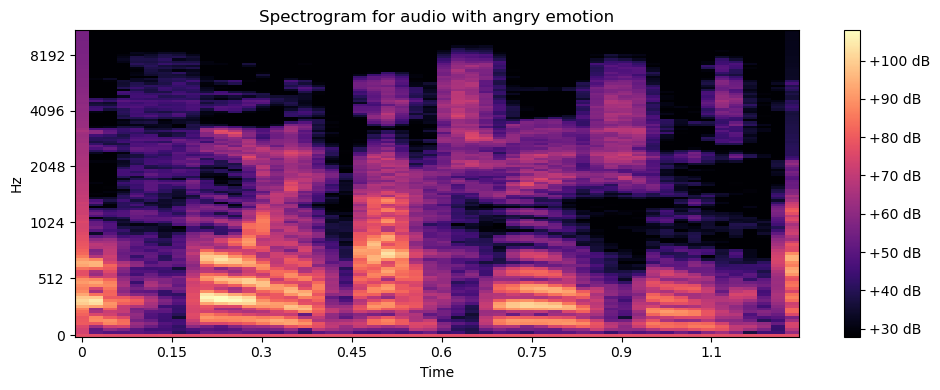

In [16]:
path_angry = np.array(SAVEE.path[SAVEE.emotions=='angry'])[1]
create_wave_plot(path_angry, 'angry')
show_melspectrogram(path_angry, 'angry')

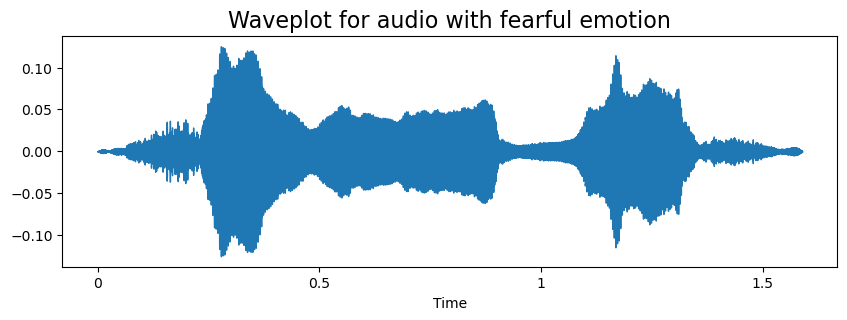

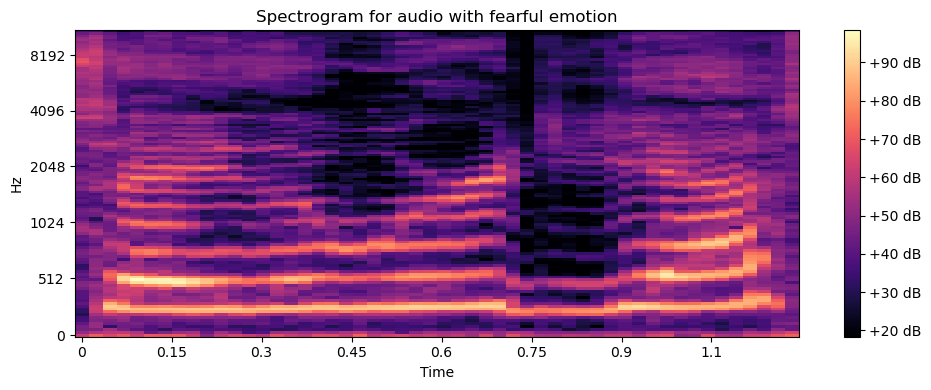

In [17]:
path_fearful = np.array (TESS.path[TESS.emotions=='fearful'])[1]
create_wave_plot (path_fearful, 'fearful')
show_melspectrogram (path_fearful, 'fearful')

In [18]:
df = pd.concat([Ravdess, SAVEE, TESS], axis=0, ignore_index=True)
df = df[df['emotions'] != 'calm']

In [19]:
groups = df.groupby('emotions')
groups.size() 

emotions
angry        652
disgust      652
fearful      652
happy        652
neutral      616
sad          652
surprised    652
dtype: int64

/var/folders/tx/hpsj6hmd5d35_szvgyc0nt3w0000gn/T/ipykernel_63630/3309811957.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot (data=df, x ='emotions',palette='husl')


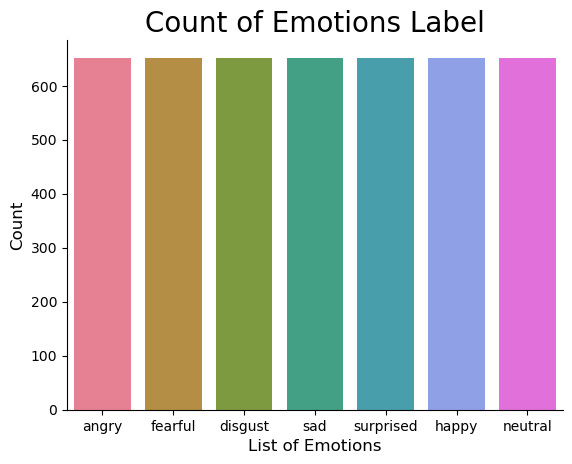

In [20]:

neutral_df = df[df['emotions'] == 'neutral']
random_neutral = neutral_df.sample (n=groups.size().max()-groups.size().min())
df = pd.concat([df,random_neutral],ignore_index=True)
plt.title ("Count of Emotions Label",fontsize = 20)
sns.countplot (data=df, x ='emotions',palette='husl')
plt.xlabel ('List of Emotions',fontsize = 12)
plt.ylabel ('Count',fontsize = 12)
sns.despine (top=True, right = True,left =False,bottom=False)
plt.show ()


In [21]:
from tqdm import tqdm

# 在 tqdm 中启用 Pandas 的进度条
tqdm.pandas(desc="Extracting Features")

# 使用带进度条的特征提取
print("Processing original audio features:")
origin = df['path'].progress_apply(lambda x: create_origin_mfcc(x))

print("Processing noisy audio features:")
noise = df['path'].progress_apply(lambda x: create_noise_mfcc(x))

print("Processing pitch-shifted audio features:") # 音高变换
pitch = df['path'].progress_apply(lambda x: create_pitch_mfcc(x))

print("Processing time-stretched audio features:") # 时间拉伸
stretch = df['path'].progress_apply(lambda x: create_stretch_mfcc(x))


Processing original audio features:


Extracting Features: 100%|█████████████████| 4564/4564 [00:16<00:00, 277.44it/s]


Processing noisy audio features:


Extracting Features: 100%|█████████████████| 4564/4564 [00:17<00:00, 256.71it/s]


Processing pitch-shifted audio features:


Extracting Features: 100%|██████████████████| 4564/4564 [00:48<00:00, 94.24it/s]


Processing time-stretched audio features:


Extracting Features: 100%|██████████████████| 4564/4564 [00:50<00:00, 91.13it/s]


In [22]:
# 合并所有特征
X_data = np.array(list(origin) + list(noise) + list(pitch) + list(stretch))

# 确保情感标签匹配
y_data = np.array(list(df['emotions']) * 4)  # 复制4倍以匹配 X_data

# 训练集、测试集划分
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# One-Hot 编码
ohe = OneHotEncoder(sparse_output=False)  # 适用于 scikit-learn 1.0+
y_train = ohe.fit_transform(y_train.reshape(-1, 1))
y_test = ohe.transform(y_test.reshape(-1, 1))

# 转换 One-Hot 编码回到类别索引
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# 训练 SVM
from sklearn.svm import SVC
model_SVM = SVC(C=1.0, kernel='rbf', random_state=42)
model_SVM.fit(X_train, y_train_labels)

# 预测
y_pred = model_SVM.predict(X_test)

# 转换预测结果回到类别名称
y_pred_labels = np.array([ohe.categories_[0][i] for i in y_pred])
y_test_labels_names = np.array([ohe.categories_[0][i] for i in y_test_labels])

# 评估模型
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_test_labels_names, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

       angry       0.71      0.74      0.73       546
     disgust       0.56      0.73      0.64       518
     fearful       0.82      0.74      0.78       541
       happy       0.74      0.57      0.64       540
     neutral       0.77      0.76      0.77       472
         sad       0.74      0.68      0.71       522
   surprised       0.64      0.70      0.67       513

    accuracy                           0.70      3652
   macro avg       0.71      0.70      0.70      3652
weighted avg       0.71      0.70      0.70      3652



In [23]:
# One-Hot 编码转为类别标签
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print("y_train_labels Shape:", y_train_labels.shape)
print("y_test_labels Shape:", y_test_labels.shape)

# 训练 SVM
model_SVM = SVC(C=1.0, kernel='rbf', random_state=42)
model_SVM.fit(X_train, y_train_labels)

# 模型预测
y_pred = model_SVM.predict(X_test)

# 转换预测结果回到类别名称（可选）
y_pred_labels = ohe.categories_[0][y_pred]  # 获取类别名称
y_test_labels_names = ohe.categories_[0][y_test_labels]  # 获取真实类别名称

# 评估模型
print("Classification Report:")
print(classification_report(y_test_labels_names, y_pred_labels))


y_train_labels Shape: (14604,)
y_test_labels Shape: (3652,)
Classification Report:
              precision    recall  f1-score   support

       angry       0.71      0.74      0.73       546
     disgust       0.56      0.73      0.64       518
     fearful       0.82      0.74      0.78       541
       happy       0.74      0.57      0.64       540
     neutral       0.77      0.76      0.77       472
         sad       0.74      0.68      0.71       522
   surprised       0.64      0.70      0.67       513

    accuracy                           0.70      3652
   macro avg       0.71      0.70      0.70      3652
weighted avg       0.71      0.70      0.70      3652



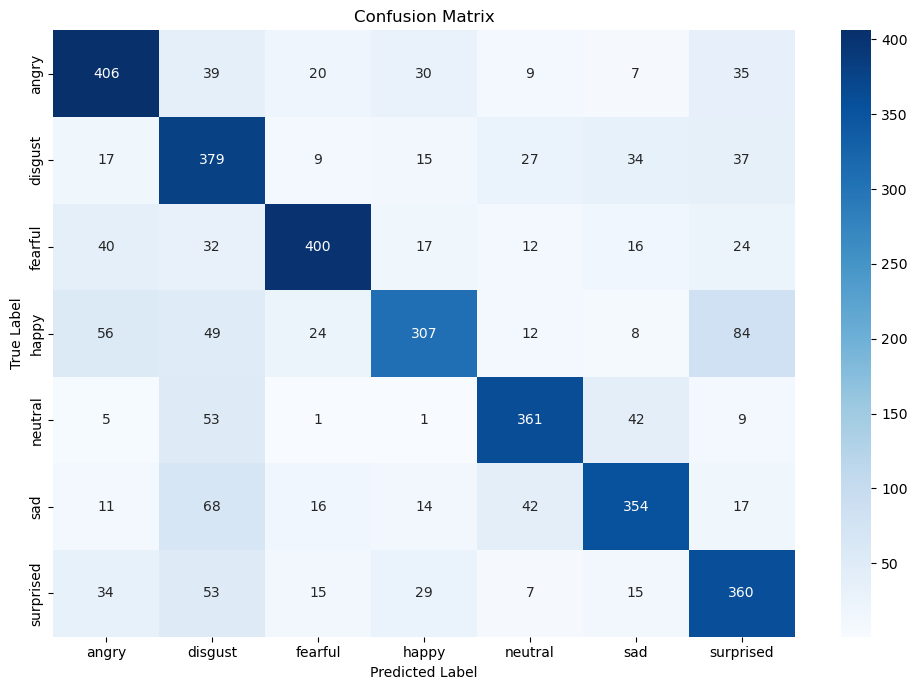

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# 生成混淆矩阵
cm = confusion_matrix(y_test_labels, y_pred, labels=np.arange(len(ohe.categories_[0])))

# 设置图像大小
plt.figure(figsize=(10, 7))

# 绘制热力图
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=ohe.categories_[0],
            yticklabels=ohe.categories_[0])

# 添加标题和坐标轴标签
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 保存图像
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)  # 保存为高分辨率 PNG 文件
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


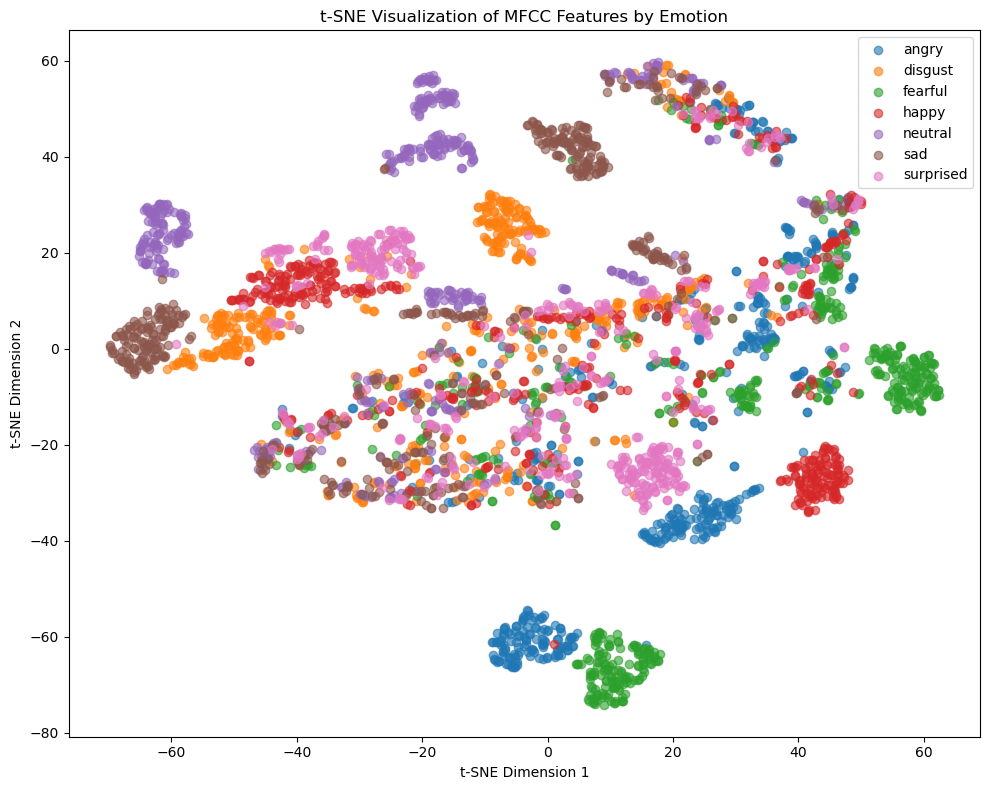

In [34]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 如果还没定义 label_names，则定义它
label_names = ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# 降维
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_embedded = tsne.fit_transform(X_test)

# 绘图
plt.figure(figsize=(10, 8))
for i, label in enumerate(label_names):
    plt.scatter(X_embedded[y_test_labels == i, 0],
                X_embedded[y_test_labels == i, 1],
                label=label, alpha=0.6)
plt.title("t-SNE Visualization of MFCC Features by Emotion")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.tight_layout()
plt.savefig("tsne_emotion_visualization.png", dpi=300)
plt.show()


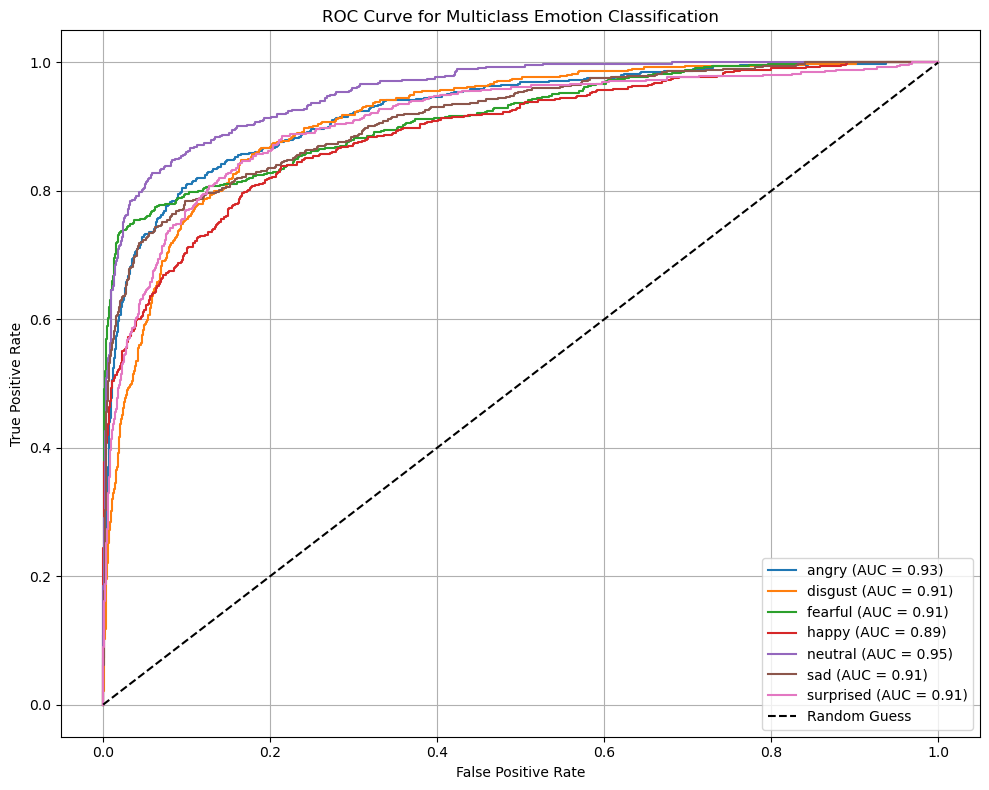

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC

# 初始化 SVM 模型，开启概率估计
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# 拟合模型
svm_model.fit(X_train, y_train_labels)


# 获取测试集每个样本的类别概率
y_proba = svm_model.predict_proba(X_test)




# 设置情绪类别名称（根据你的分类顺序）
label_names = ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
n_classes = len(label_names)

# 将真实标签 one-hot 编码
y_test_binarized = label_binarize(y_test_labels, classes=np.arange(n_classes))

# y_proba 是模型对每个样本的每类预测概率，形状为 [n_samples, n_classes]

# 初始化绘图
plt.figure(figsize=(10, 8))

# 为每个类别绘制 ROC 曲线
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_names[i]} (AUC = {roc_auc:.2f})')

# 添加对角线（随机预测参考线）
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# 图像美化
plt.title('ROC Curve for Multiclass Emotion Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# 保存图像
plt.savefig("roc_curve_multiclass.png", dpi=300)
plt.show()
